# Energy Preserving Operator Inference Optimization Example using Burger's Equation

## Packages

In [1]:
using DataFrames
using Distributions
using LinearAlgebra
using Plots
using ProgressMeter
using Random
using SparseArrays
using Statistics
using NaNStatistics
using JLD2

## Initial Setup

In [2]:
include("../src/model/Burgers.jl")
include("../src/LiftAndLearn.jl")
const LnL = LiftAndLearn

Main.LiftAndLearn

In [3]:
# First order Burger's equation setup
burger = Burgers(
    [0.0, 1.0], [0.0, 1.0], [0.1, 1.0],
    2^(-7), 1e-4, 10
)
change_boundary_condition = false;

#### Run below to change 
- Initial condition to: sinusoidal wave
- Zero boundary condition

In [ ]:
burger.IC = sin.(pi * burger.Δx)
change_boundary_condition = true

## Check if the intrusive operators show energy preservation

In [4]:
options = LnL.OpInf_options(
    reproject=false,
    is_quad=true,
    optimization="NC",  #!!! This options changes the problem into an optimization problem
    opt_verbose=false,
    initial_guess_for_opt=true,
    which_quad_term="F",
    N=1,
    Δt=1e-4,
    deriv_type="SI",
)

Main.LiftAndLearn.OpInf_options(true, true, false, true, false, false, true, false, "NC", false, true, "F", 0, 0, "SI", false, 1, 1, 0.0001, 0.1)

In [5]:
num_inputs = 10
rmin = 4
rmax = 25

25

In [5]:
Utest = ones(burger.Tdim - 1, 1);  # Reference input/boundary condition for OpInf testing 

# Error Values 
Qint = Matrix{Vector{Matrix{Float64}}}(undef, rmax-(rmin-1), burger.Pdim)
Hint = Matrix{Matrix{Float64}}(undef, rmax-(rmin-1), burger.Pdim)

# Downsampling rate
DS = 200

@showprogress for i in 1:length(burger.μs)
    μ = burger.μs[i]

    ## Create testing data
    A, B, F = burger.generateABFmatrix(burger, μ)
    C = ones(1, burger.Xdim) / burger.Xdim
    op_burger = LnL.operators(A=A, B=B, C=C, F=F)

    ## training data for inferred dynamical models
    Urand = rand(burger.Tdim - 1, num_inputs)
    Xall = Vector{Matrix{Float64}}(undef, num_inputs)
    # Xdotall = Vector{Matrix{Float64}}(undef, num_inputs)
    for j in 1:num_inputs
        states = LnL.semiImplicitEuler(A, B, F, Urand[:, j], burger.t, burger.IC)
        tmp = states[:, 2:end]
        Xall[j] = tmp[:, 1:DS:end]  # downsample data
        # tmp = (states[:, 2:end] - states[:, 1:end-1]) / burger.Δt
        # Xdotall[j] = tmp[:, 1:DS:end]  # downsample data
    end
    X = reduce(hcat, Xall)
    
    # compute the POD basis from the training data
    tmp = svd(X)
    Vrmax = tmp.U[:, 1:rmax]

    # Compute the values for the intrusive model from the basis of the training data
    op_int = LnL.intrusiveMR(op_burger, Vrmax, options)

    for j = rmin:rmax
        Vr = Vrmax[:, 1:j]  # basis
        
        # Integrate the intrusive model
        # Fint_extract = LnL.extractF(op_int.F, j)
        Hint_extract = LnL.extractH(op_int.H, j)

        # Store the H and Q matrices
        Hint[j-(rmin-1), i] = Hint_extract
        Qint[j-(rmin-1), i] = LnL.H2Q(Hint_extract)
    end
end

# Compute the constraint residuals for all the Q and H matrices
ϵQ_int, ϵH_int = LnL.constraintResidual(Qint, Hint, rmin, rmax, burger.Pdim);

# Compute the symmetru residuals for all the Q and H matrices
σQ_int, σH_int = LnL.symmetryResidual(Qint, Hint, rmin, rmax, burger.Pdim);

Progress: 100%|█████████████████████████████████████████| Time: 0:04:06


In [11]:
save("data/intrusive_residuals.jld2", Dict("ϵH" => ϵH_int, "ϵQ" => ϵQ_int, "σH" => σH_int, "σQ" => σQ_int))

### Plot using the save data (if you don't want to rerun it)

In [35]:
ϵH_int, ϵQ_int, σH_int, σQ_int = load("data/intrusive_residuals.jld2", "ϵH", "ϵQ", "σH", "σQ");

In [ ]:
# Plot the constraint residuals for the intrusive operators
plot(rmin:rmax, mean(abs.(ϵQ_int), dims=2), marker=(:diamond, 8, :green), color=:green, label="Q_int")
plot!(rmin:rmax, mean(abs.(ϵH_int), dims=2), marker=(:hexagon, :red), color=:red, ls=:dash, label="H_int")
plot!(yscale=:log10, majorgrid=true, minorgrid=true, legend=:bottomright)
xticks!(rmin:rmax)
xlabel!("dimension n")
ylabel!("Mean Absolute Constraint Residual")

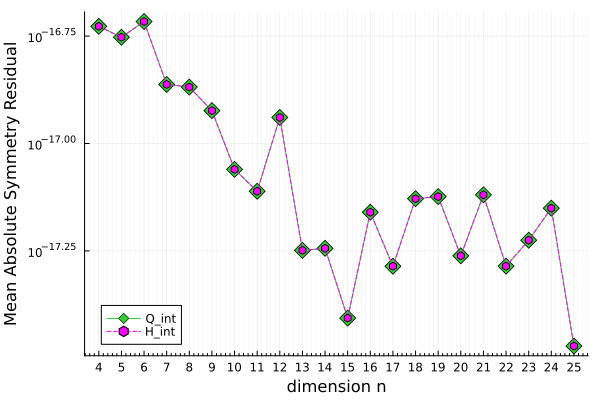

In [7]:
# Plot the symmetry residuals for the energy-preserving hard constrained 
plot(rmin:rmax, mean(abs.(σQ_int), dims=2), marker=(:diamond, 8, :limegreen), color=:limegreen, label="Q_int")
plot!(rmin:rmax, mean(abs.(σH_int), dims=2), marker=(:hexagon, :magenta), color=:magenta, ls=:dash, label="H_int")
plot!(yscale=:log10, majorgrid=true, minorgrid=true, legend=:bottomleft)
xticks!(rmin:rmax)
xlabel!("dimension n")
ylabel!("Mean Absolute Symmetry Residual")

In [8]:
DF1 = DataFrame(ϵH_int, :auto)

22×10 DataFrame
 Row │ x1            x2            x3           x4           x5           x6   ⋯
     │ Float64       Float64       Float64      Float64      Float64      Floa ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ -0.275827     -0.248473     -0.224278    -0.195174    -0.160248    -0.1 ⋯
   2 │ -0.00200411    0.0477294     0.0661887    0.0677675    0.0789886    0.0
   3 │ -0.0383297    -0.0183309    -0.0101868   -0.00919721  -0.010662    -0.0
   4 │  0.0065652     0.0107415     0.0157701    0.0163886    0.0171209    0.0
   5 │ -0.0330408    -0.0141034    -0.00686477  -0.00709297  -0.00976832  -0.0 ⋯
   6 │ -0.00144976    0.000509246   0.0067116    0.00558784   0.00747909   0.0
   7 │  0.0372238     0.042101      0.063079     0.0515354    0.059719     0.0
   8 │ -0.00241141   -0.000978556   0.00565428   0.00374123   0.00609125   0.0
   9 │  0.0127185     0.0165528     0.0292008    0.0239904    0.0304692    0.0 ⋯
  10 │  0.00269619    0.00402736    0.0448214    0.0419224    0.00756372   0.0
  11 │  0.00432095    0.00525053    0.0243252    0.0215453    0.0104905    0.0
  12 │ -0.000593858   0.00105401    0.0281809    0.0255755    0.00474326   0.0
  13 │  0.00302881   -0.00431736    0.0196539    0.0171723   -0.00463023  -0.0 ⋯
  14 │ -0.000276709   0.00184419    0.0242273    0.0190683   -0.0192881   -0.0
  15 │ -0.00499568    0.0274296     0.0437668    0.0358727   -0.0223835   -0.0
  16 │  0.00685011    0.0552236     0.0676829    0.0644327   -0.00532331  -0.0
  17 │  0.0374991     0.0611432     0.0778798    0.0864983    0.0219937    0.0 ⋯
  18 │  0.0637555     0.0474405     0.055609     0.088081     0.0378381   -0.0
  19 │  0.0338612     0.0329532     0.0530708    0.0721342    0.0362935   -0.0
  20 │  0.0429647     0.0330334     0.0410937    0.0578321    0.0315904   -0.0
  21 │  0.0411379     0.0318739     0.0293072    0.0516686    0.0276039   -0.0 ⋯
  22 │  0.0359491     0.0266601     0.0294374    0.0441394    0.024701    -0.0
                                                               5 columns omitted

In [20]:
DF2 = DataFrame(σH_int, :auto)

22×10 DataFrame
 Row │ x1            x2            x3            x4            x5            x ⋯
     │ Float64       Float64       Float64       Float64       Float64       F ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ -2.08167e-17  -1.04083e-17   0.0          -1.04083e-17   0.0            ⋯
   2 │ -2.4869e-17    2.4869e-17   -1.42109e-17   1.06581e-17  -8.88178e-18
   3 │  9.25186e-18   2.05597e-17  -1.43918e-17  -8.22387e-18  -3.08395e-17  -
   4 │  2.84839e-17   1.29472e-17  -2.3305e-17   -5.17888e-18   5.17888e-18
   5 │  2.08167e-17  -3.46945e-18   0.0           4.33681e-17  -5.20417e-18  - ⋯
   6 │  4.87341e-18   2.61946e-17  -1.70569e-17   2.13212e-17  -8.52846e-18  -
   7 │ -5.32907e-18   9.76996e-18  -3.55271e-18   2.13163e-17  -7.10543e-18
   8 │ -3.33651e-18   8.67492e-18   0.0           1.13441e-17  -6.67302e-19
   9 │ -1.69617e-17   1.69617e-17  -1.61908e-17   1.05368e-17  -1.94032e-17  - ⋯
  10 │ -8.08537e-19   1.29366e-17   3.23415e-18   7.68111e-18   3.63842e-18
  11 │ -8.41568e-18  -8.54718e-19  -3.88416e-18  -6.14992e-18  -1.94208e-18
  12 │  2.10531e-18   1.31582e-17  -5.26328e-19  -3.6843e-18   -5.46065e-18  -
  13 │  4.35036e-18   1.19262e-17  -1.95156e-18   5.63785e-18  -1.09504e-17  - ⋯
  14 │ -7.59281e-18   1.51856e-17   2.16938e-18   8.13516e-19  -2.53094e-18  -
  15 │  4.11194e-18   9.06149e-18  -1.49248e-17  -9.28993e-18  -1.82753e-18  -
  16 │  3.36676e-18   1.37584e-17  -3.07541e-18  -8.80538e-18   4.33795e-18
  17 │ -2.498e-18     1.75415e-17  -5.66214e-18   4.16334e-18   5.89806e-18  - ⋯
  18 │  3.93211e-18   1.83059e-17  -1.51051e-18   8.34376e-18   5.4666e-18   -
  19 │  2.08532e-18   8.34127e-18   4.46258e-18   5.00476e-19   3.89954e-18
  20 │  1.35048e-18   1.68536e-17   2.00747e-19   1.90892e-17  -7.1539e-18   -
  21 │ -7.60548e-18   1.12115e-17  -2.56996e-18   7.88657e-18   3.3811e-18     ⋯
  22 │  1.42109e-18   5.92593e-18   1.19371e-18   2.27374e-18   2.52953e-18
                                                               5 columns omitted

We can see that the intrusive model also preserves energy but in a very relaxed way. It is not very conservative.

## Check If Extracting from Higher-Order Operators Preserved Energy (Hard Constrained)

In [ ]:
start = time()
num_inputs = 10
rmin = 4
rmax = 14

Q = Matrix{Vector{Matrix{Float64}}}(undef, rmax-(rmin-1), burger.Pdim)
H = Matrix{Matrix{Float64}}(undef, rmax-(rmin-1), burger.Pdim)

# Downsampling rate
DS = 200

options = LnL.OpInf_options(
    reproject=false,
    is_quad=true,
    optimization="EPHC",  #!!! This options changes the problem into an optimization problem
    opt_verbose=false,
    initial_guess_for_opt=true,
    which_quad_term="H",
    N=1,
    Δt=1e-4,
    deriv_type="SI",
    has_output=false  # suppress output
)

println("[INFO] Compute inferred and intrusive operators and calculate the errors")
for i in 1:length(burger.μs)
    μ = burger.μs[i]
    
    # Get FOM
    A, B, F = burger.generateABFmatrix(burger, μ)
    C = ones(1, burger.Xdim) / burger.Xdim
    op_burger = LnL.operators(A=A, B=B, F=F)

    ## training data for inferred dynamical models
    Urand = rand(burger.Tdim - 1, num_inputs)
    Xall = Vector{Matrix{Float64}}(undef, num_inputs)
    Xdotall = Vector{Matrix{Float64}}(undef, num_inputs)
    for j in 1:num_inputs
        states = LnL.semiImplicitEuler(A, B, F, Urand[:, j], burger.t, burger.IC)
        tmp = states[:, 2:end]
        Xall[j] = tmp[:, 1:DS:end]  # downsample data
        tmp = (states[:, 2:end] - states[:, 1:end-1]) / burger.Δt
        Xdotall[j] = tmp[:, 1:DS:end]  # downsample data
    end
    X = reduce(hcat, Xall)
    R = reduce(hcat, Xdotall)
    Urand = Urand[1:DS:end, :]  # downsample data
    U = vec(Urand)[:,:]  # vectorize
    Y = C * X
    
    # compute the POD basis from the training data
    tmp = svd(X)
    Vrmax = tmp.U[:, 1:rmax]
    
    # Compute the inferred operators from the training data 
    op_inf = LnL.inferOp(X, U, Y, Vrmax, Vrmax' * R, options)
    
    for j = rmin:rmax
        # Store the H and Q matrices
        H_extract = LnL.extractH(op_inf.H, j)
        H[j-(rmin-1), i] = H_extract
        Q[j-(rmin-1), i] = LnL.H2Q(H_extract)
    end
end

# Compute the constraint residuals for all the Q and H matrices
ϵQ_ephc_ex, ϵH_ephc_ex = LnL.constraintResidual(Q, H, rmin, rmax, burger.Pdim);

# Compute the symmetru residuals for all the Q and H matrices
σQ_ephc_ex, σH_ephc_ex = LnL.symmetryResidual(Q, H, rmin, rmax, burger.Pdim);

println("[INFO] ($(time()-start)) To complete process...")

In [ ]:
# Plot the constraint residuals for the energy-preserving hard constrained 
plot(rmin:rmax, abs.(mean(ϵQ_ephc_ex, dims=2)), marker=(:diamond, 8, :green), color=:green, label="Q_ephc")
plot!(rmin:rmax, abs.(mean(ϵH_ephc_ex, dims=2)), marker=(:hexagon, :red), color=:red, ls=:dash, label="H_ephc")
plot!(yscale=:log10, majorgrid=true, minorgrid=true, legend=:topleft)
xticks!(rmin:rmax)
xlabel!("dimension n")
ylabel!("Mean Absolute Constraint Residual")

In [ ]:
# Plot the symmetry residuals for the energy-preserving hard constrained 
plot(rmin:rmax, abs.(mean(σQ_ephc_ex, dims=2)), marker=(:diamond, 8, :limegreen), color=:limegreen, label="Q_ephc")
plot!(rmin:rmax, abs.(mean(σH_ephc_ex, dims=2)), marker=(:hexagon, :magenta), color=:magenta, ls=:dash, label="H_ephc")
# plot!(yscale=:log10, majorgrid=true, minorgrid=true, legend=:topleft)
plot!(majorgrid=true, minorgrid=true, legend=:topleft)
xticks!(rmin:rmax)
xlabel!("dimension n")
ylabel!("Mean Absolute Symmetry Residual")

In [ ]:
DataFrame(ϵH_ephc_ex, :auto)

In [ ]:
DataFrame(σH_ephc_ex, :auto)

## Energy Preserving Hard Equality Constraint Optimization

### Important Parameters

In [4]:
num_inputs = 10
rmin = 4
rmax = 20

options = LnL.OpInf_options(
    reproject=false,
    is_quad=true,
    optimization="NC",  #!!! This options changes the problem into an optimization problem
    opt_verbose=false,
    initial_guess_for_opt=false,
    which_quad_term="F",
    N=1,
    Δt=1e-4,
    deriv_type="SI",
    has_output=false  # suppress output
)

# Downsampling rate
DS = 100;

### Generate Training Data

In [5]:
# Store values
Xtr = Array{Matrix{Real}}(undef, burger.Pdim)
Rtr = Array{Matrix{Real}}(undef, burger.Pdim)
Utr = Array{Matrix{Real}}(undef, burger.Pdim)
Xtr_all = Array{Matrix{Real}}(undef, burger.Pdim)
Utr_all = Array{Vector{Real}}(undef, burger.Pdim)
Ytr = Array{Matrix{Real}}(undef, burger.Pdim)
Vrmax = Array{Matrix{Real}}(undef, burger.Pdim)
op_fom_tr = Array{LnL.operators}(undef, burger.Pdim)

println("[INFO] Generate Training Data")
@showprogress for i in 1:length(burger.μs)
    μ = burger.μs[i]
    
    # Generate the FOM system matrices 
    A, B, F = burger.generateABFmatrix(burger, μ)
    C = ones(1, burger.Xdim) / burger.Xdim
    op_fom_tr[i] = LnL.operators(A=A, B=B, C=C, F=F)
    
    ## training data for OpInf
    Urand = rand(burger.Tdim - 1, num_inputs)
    Xall = Vector{Matrix{Float64}}(undef, num_inputs)
    Xdotall = Vector{Matrix{Float64}}(undef, num_inputs)
    for j in 1:num_inputs
        states = LnL.semiImplicitEuler(A, B, F, Urand[:, j], burger.t, burger.IC)
            
        # Just take the first one for the training data
        if j == 1
            Utr_all[i] = Urand[:,1]
            Xtr_all[i] = states
        end
        
        tmp = states[:, 2:end]
        Xall[j] = tmp[:, 1:DS:end]  # downsample data
        tmp = (states[:, 2:end] - states[:, 1:end-1]) / burger.Δt
        Xdotall[j] = tmp[:, 1:DS:end]  # downsample data
    end
    
    X_::Matrix{Float64} = reduce(hcat, Xall)
    R_::Matrix{Float64} = reduce(hcat, Xdotall)
    Urand = Urand[1:DS:end, :]  # downsample data
    U_::Matrix{Float64} = vec(Urand)[:,:]  # vectorize
    Y_::Matrix{Float64} = C * X_
    
    # Compute the POD basis from the training data
    tmp = svd(X_)
    Vrmax_::Matrix{Float64} = tmp.U[:, 1:rmax]
    
    # Store important data values
    Xtr[i] = X_
    Rtr[i] = R_
    Ytr[i] = Y_
    Utr[i] = U_[:,:]
    Vrmax[i] = Vrmax_
end

# Save data
save(
    "data/epOpInf_data.jld2", 
    Dict("Xtr" => Xtr, "Utr" => Utr, "Ytr" => Ytr, "Rtr" => Rtr, "Vrmax" => Vrmax, 
        "op_fom_tr" => op_fom_tr, "Xtr_all" => Xtr_all, "Utr_all" => Utr_all)
)

[INFO] Generate Training Data


Progress: 100%|█████████████████████████████████████████| Time: 0:02:55


### Generate Test Data

In [6]:
# Reference input/boundary condition for 
if change_boundary_condition
    Utest = zeros(burger.Tdim - 1, 1)
else
    Utest = ones(burger.Tdim - 1, 1)
end

# Store values
Xtst = Array{Matrix{Real}}(undef, burger.Pdim)
op_fom_tst = Array{LnL.operators}(undef, burger.Pdim)

# Generate the viscosity coefficients for the test
μs = vcat([0.2, 0.4, 0.6, 0.8, 1.0], rand(Uniform(0.0,1.0),5,1))

println("[INFO] Generate Test Data")
@showprogress for i in 1:length(μs)
    μ = μs[i]
    
    # Generate the FOM system matrices 
    A, B, F = burger.generateABFmatrix(burger, μ)
    # C = ones(1, burger.Xdim) / burger.Xdim
    op_fom_tst[i] = LnL.operators(A=A, B=B, F=F)
    
    Xtst[i] = LnL.semiImplicitEuler(A, B, F, Utest, burger.t, burger.IC)
end

# Load the data so I can append to it
Data = load("data/epOpInf_data.jld2")

# Append new data to the data dictionary
Data["Xtst"] = Xtst
Data["op_fom_tst"] = op_fom_tst
Data["μ_rand"] = μs

# Save data
save("data/epOpInf_data.jld2", Data)

[INFO] Generate Test Data


Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


### Obtain intrusive operators and non-constrained OpInf operators

In [5]:
# Store values
op_int = Array{LnL.operators}(undef, burger.Pdim)
op_nc_opinf = Array{LnL.operators}(undef, burger.Pdim)

# Load the data dictionary
Data = load("data/epOpInf_data.jld2");

println("[INFO] Compute the intrusive operators and nc-OpInf operators")
for i in 1:length(burger.μs)
    Vrmax_::Matrix{Float64} = Data["Vrmax"][i]
    # Compute the values for the intrusive model from the basis of the training data
    op_int[i] = LnL.intrusiveMR(Data["op_fom_tr"][i], Vrmax_, options)
    
    # Compute non-constrained OpInf
    op_nc_opinf[i] = LnL.inferOp(Data["Xtr"][i], Data["Utr"][i], Data["Ytr"][i], Vrmax_, Vrmax_' * Data["Rtr"][i], options, op_int[i])
    
    println("[DEBUG] Loop $(i) out of 10 completed...") 
end

# Save to data
Data["op_int"] = op_int
Data["op_nc_opinf"] = op_nc_opinf
save("data/epOpInf_data.jld2", Data)

[INFO] Compute the intrusive operators and nc-OpInf operators


┌ Warning: The addition operator has been used on JuMP expressions a large number of times. This warning is safe to ignore but may indicate that model generation is slower than necessary. For performance reasons, you should not add expressions in a loop. Instead of x += y, use add_to_expression!(x,y) to modify x in place. If y is a single variable, you may also use add_to_expression!(x, coef, y) for x += coef*y.
└ @ JuMP ~/.julia/packages/JuMP/pQApG/src/operators.jl:270



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

[DEBUG] Constraint        = Non-Constrained
[INFO] order              = 20
[INFO] termination_status = LOCALLY_SOLVED
[INFO] primal_status      = FEASIBLE_POINT
[INFO] objective_value    = 3.6089155245146698e-6

[DEBUG] Loop 1 out of 10 completed...
[DEBUG] Constraint        = Non-Constrained
[INFO] order              = 20
[INFO] termination_status = LOCALLY_SOLVED
[INFO] primal_status      = FEASIBLE_POINT
[INFO] objective_value    = 1.5846587185488194e-7

[DEBUG] Loop 2 out of 10 completed...
[DEBUG] Constraint        = Non-Constrained
[INFO] order              = 20
[INFO] termination_status = LOCALLY_SO

### Obtain operators for ephec-OpInf

In [ ]:
# Switch optimization scheme
options.optimization = "EPHEC"

# Store values
op_ephec_opinf = Array{LnL.operators}(undef, burger.Pdim)

# Load the data dictionary
Data = load("data/epOpInf_data.jld2");

println("[INFO] Compute the ephec-OpInf operators")
for i in 1:length(burger.μs)
    Vrmax_::Matrix{Float64} = Data["Vrmax"][i]
    
    # Compute non-constrained OpInf
    op_ephec_opinf[i] = LnL.inferOp(Data["Xtr"][i], Data["Utr"][i], Data["Ytr"][i], Vrmax_, Vrmax_' * Data["Rtr"][i], options)
    
    println("[DEBUG] Loop $(i) out of 10 completed...") 
end

# Save to data
Data["op_ephec_opinf"] = op_ephec_opinf
save("data/epOpInf_data.jld2", Data)

[INFO] Compute the ephec-OpInf operators


┌ Warning: The addition operator has been used on JuMP expressions a large number of times. This warning is safe to ignore but may indicate that model generation is slower than necessary. For performance reasons, you should not add expressions in a loop. Instead of x += y, use add_to_expression!(x,y) to modify x in place. If y is a single variable, you may also use add_to_expression!(x, coef, y) for x += coef*y.
└ @ JuMP ~/.julia/packages/JuMP/pQApG/src/operators.jl:270



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

[DEBUG] Constraint        = Energy-Preserving Hard Equality Constraint
[INFO] order              = 20
[INFO] termination_status = LOCALLY_INFEASIBLE
[INFO] primal_status      = INFEASIBLE_POINT
[INFO] objective_value    = 0.42525913741115207



### Test & Analyze (Training Data)

In [6]:
function quadEnergyRate(X::Vector, F::Matrix)
    return X' * F * LnL.vech(X * X')
end

function quadEnergyRate(X::Matrix, F::Matrix)
    _, m = size(X)
    S = zeros(m,1)
    for i in 1:m
        S[i] = X[:,i]' * F * LnL.vech(X[:,i] * X[:,i]')
    end
    return S
end

quadEnergyRate (generic function with 2 methods)

In [7]:
# Error values
train_proj_err = zeros(rmax - (rmin-1), burger.Pdim) 
train_state_err = Dict(
    :int => zeros(rmax-rmin+1, burger.Pdim),
    :nc_OpInf => zeros(rmax-rmin+1, burger.Pdim),
    :ephec_OpInf => zeros(rmax-rmin+1, burger.Pdim)
)
train_En = Dict(
    :int => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    :nc_OpInf => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    :ephec_OpInf => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    :fom => Array{VecOrMat{Float64}}(undef, burger.Pdim)
)
train_CR = Dict(
    :int => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    :nc_OpInf => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    :ephec_OpInf => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    :fom => Array{VecOrMat{Float64}}(undef, burger.Pdim)
)

Data = load("data/epOpInf_data.jld2")

DS = 20
println("[INFO] Analyze the operators with training data...")
@showprogress for i in 1:length(burger.μs)
    op_int = Data["op_int"][i]
    op_nc_opinf = Data["op_nc_opinf"][i]
    op_ephec_opinf = Data["op_ephec_opinf"][i]
    
    Xtrain = Data["Xtr_all"][i]
    Utrain = Data["Utr_all"][i]
    Vrmax_ = Data["Vrmax"][i]
    
    # Downsample
    Xtrain = Xtrain[:,1:DS:end]
    
    # Energy of the FOM
    train_En[:fom][i] = norm.(eachcol(Xtrain), 2)
    Ffom::Matrix = Data["op_fom_tr"][i].F
    train_CR[:fom][i] = quadEnergyRate(Xtrain, Ffom)
    
    for (j,r) in enumerate(rmin:rmax)
        Vr = Vrmax_[:, 1:r]

        # Integrate the intrusive model
        Fint_extract = LnL.extractF(op_int.F, r)
        Xint = LnL.semiImplicitEuler(op_int.A[1:r, 1:r], op_int.B[1:r, :], Fint_extract, Utrain, burger.t, Vr' * burger.IC)

        # Integrate the non-constrained operator inference model
        Finf_extract_nc = LnL.extractF(op_nc_opinf.F, r)
        Xinf_nc = LnL.semiImplicitEuler(op_nc_opinf.A[1:r, 1:r], op_nc_opinf.B[1:r, :], Finf_extract_nc, Utrain, burger.t, Vr' * burger.IC)
        
        # Integrate the energy-preserving hard equality constraint operator inference model
        Finf_extract_ephec = LnL.extractF(op_ephec_opinf.F, r)
        Xinf_ephec = LnL.semiImplicitEuler(op_ephec_opinf.A[1:r, 1:r], op_ephec_opinf.B[1:r, :], Finf_extract_ephec, Utrain, burger.t, Vr' * burger.IC)
        
        # Downsample
        Xint = Xint[:, 1:DS:end]
        Xinf_nc = Xinf_nc[:, 1:DS:end]
        Xinf_ephec = Xinf_ephec[:, 1:DS:end]
        
        # Compute errors
        train_proj_err[j, i] = LnL.compProjError(Xtrain, Vr)
        train_state_err[:int][j, i] = LnL.compStateError(Xtrain, Xint, Vr)
        train_state_err[:nc_OpInf][j, i] = LnL.compStateError(Xtrain, Xinf_nc, Vr)
        train_state_err[:ephec_OpInf][j, i] = LnL.compStateError(Xtrain, Xinf_ephec, Vr)
        
        # Compute energy 
        train_En[:int][j, i] = norm.(eachcol(Xint), 2)
        train_En[:nc_OpInf][j, i] = norm.(eachcol(Xinf_nc), 2)
        train_En[:ephec_OpInf][j, i] = norm.(eachcol(Xinf_ephec), 2)
        
        # Compute the CR
        train_CR[:int][j, i] = quadEnergyRate(Xint, Fint_extract)
        train_CR[:nc_OpInf][j, i] = quadEnergyRate(Xinf_nc, Finf_extract_nc)
        train_CR[:ephec_OpInf][j, i] = quadEnergyRate(Xinf_ephec, Finf_extract_ephec)
    end
end

# Save data
Data["train_proj_err"] = train_proj_err
Data["train_state_err"] = train_state_err
Data["train_En"] = train_En
Data["train_CR"] = train_CR
save("data/epOpInf_data.jld2", Data)

[INFO] Analyze the operators with training data...


Progress: 100%|█████████████████████████████████████████| Time: 0:04:13


### Test and Analyze (Test Data)

In [8]:
test_proj_err = zeros(rmax - (rmin-1), burger.Pdim) 
test_state_err = Dict(
    :int => zeros(rmax-rmin+1, burger.Pdim),
    :nc_OpInf => zeros(rmax-rmin+1, burger.Pdim),
    :ephec_OpInf => zeros(rmax-rmin+1, burger.Pdim)
)
test_En = Dict(
    :int => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), 10),
    :nc_OpInf => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), 10),
    :ephec_OpInf => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), 10),
    :fom => Array{VecOrMat{Float64}}(undef, 10),
)
test_CR = Dict(
    :int => Array{Matrix{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    :nc_OpInf => Array{Matrix{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    :ephec_OpInf => Array{Matrix{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    :fom => Array{Matrix{Float64}}(undef, burger.Pdim)
)

Data = load("data/epOpInf_data.jld2")

DS = 20
Utest = ones(burger.Tdim - 1, 1);  
println("[INFO] Analyze the operators with testing data...")
@showprogress for i in 1:length(Data["μ_rand"])
    op_int = Data["op_int"][i]
    op_nc_opinf = Data["op_nc_opinf"][i]
    op_ephec_opinf = Data["op_ephec_opinf"][i]
    
    Xtest = Data["Xtst"][i]
    Vrmax_ = Data["Vrmax"][i]
    
    # Downsample
    Xtest = Xtest[:,1:DS:end]
    
    # Energy of the FOM
    test_En[:fom][i] = norm.(eachcol(Xtest), 2)
    Ffom::Matrix = Data["op_fom_tst"][i].F
    test_CR[:fom][i] = quadEnergyRate(Xtest, Ffom)
    
    for (j,r) in enumerate(rmin:rmax)
        Vr = Vrmax_[:, 1:r]

        # Integrate the intrusive model
        Fint_extract = LnL.extractF(op_int.F, r)
        Xint = LnL.semiImplicitEuler(op_int.A[1:r, 1:r], op_int.B[1:r, :], Fint_extract, Utest, burger.t, Vr' * burger.IC)

        # Integrate the non-constrained operator inference model
        Finf_extract_nc = LnL.extractF(op_nc_opinf.F, r)
        Xinf_nc = LnL.semiImplicitEuler(op_nc_opinf.A[1:r, 1:r], op_nc_opinf.B[1:r, :], Finf_extract_nc, Utest, burger.t, Vr' * burger.IC)
        
        # Integrate the energy-preserving hard equality constraint operator inference model
        Finf_extract_ephec = LnL.extractF(op_ephec_opinf.F, r)
        Xinf_ephec = LnL.semiImplicitEuler(op_ephec_opinf.A[1:r, 1:r], op_ephec_opinf.B[1:r, :], Finf_extract_ephec, Utest, burger.t, Vr' * burger.IC)
        
        # Downsample
        Xint = Xint[:, 1:DS:end]
        Xinf_nc = Xinf_nc[:, 1:DS:end]
        Xinf_ephec = Xinf_ephec[:, 1:DS:end]
        
        # Compute errors
        test_proj_err[j, i] = LnL.compProjError(Xtest, Vr)
        test_state_err[:int][j, i] = LnL.compStateError(Xtest, Xint, Vr)
        test_state_err[:nc_OpInf][j, i] = LnL.compStateError(Xtest, Xinf_nc, Vr)
        test_state_err[:ephec_OpInf][j, i] = LnL.compStateError(Xtest, Xinf_ephec, Vr)
        
        # Compute energy 
        test_En[:int][j, i] = norm.(eachcol(Xint), 2)
        test_En[:nc_OpInf][j, i] = norm.(eachcol(Xinf_nc), 2)
        test_En[:ephec_OpInf][j, i] = norm.(eachcol(Xinf_ephec), 2)
        
        # Compute the CR
        test_CR[:int][j, i] = quadEnergyRate(Xint, Fint_extract)
        test_CR[:nc_OpInf][j, i] = quadEnergyRate(Xinf_nc, Finf_extract_nc)
        test_CR[:ephec_OpInf][j, i] = quadEnergyRate(Xinf_ephec, Finf_extract_ephec)
    end
end

# Save data
Data["test_proj_err"] = test_proj_err
Data["test_state_err"] = test_state_err
Data["test_En"] = test_En
Data["test_CR"] = test_CR
save("data/epOpInf_data.jld2", Data)

[INFO] Analyze the operators with testing data...


Progress: 100%|█████████████████████████████████████████| Time: 0:04:42


### Verifications

In [6]:
Data = load("data/epOpInf_data.jld2")

Dict{String, Any} with 8 entries:
  "Utr"       => Matrix{Real}[[0.0424707; 0.968302; … ; 0.0639378; 0.916509;;],…
  "Xtr_all"   => Matrix{Real}[[0.0 4.24749e-6 … 0.848587 0.848719; 0.0 5.32389e…
  "Utr_all"   => Vector{Real}[[0.0424707, 0.380789, 0.143087, 0.991381, 0.26689…
  "Xtr"       => Matrix{Real}[[4.24749e-6 0.00995325 … 0.799077 0.825235; 5.323…
  "Vrmax"     => Matrix{Real}[[-0.195942 -0.220011 … -1.80847e-5 -6.85113e-6; -…
  "Ytr"       => Matrix{Real}[[1.12382e-24 -3.05518e-20 … 7.05352e-16 7.5388e-1…
  "op_fom_tr" => Main.LiftAndLearn.operators[operators([1.0 0.0 … 0.0 0.0; 1638…
  "Rtr"       => Matrix{Real}[[0.0424749 0.978256 … 0.863015 1.74174; 0.0053238…

In [7]:
Afom = Data["op_fom_tr"][1].A
F = eigen(Afom)
F.values

129-element Vector{Float64}:
 -6552.6130891037255
 -6549.652950893107
 -6544.721368444739
 -6537.821312359452
 -6528.956938973067
 -6518.133587852593
 -6505.357778580096
 -6490.637206825313
 -6473.980739710257
 -6455.398410467907
 -6434.901412398514
 -6412.502092127327
 -6388.213942167267
     ⋮
   -98.20158953211957
   -79.61926028975006
   -62.96279317469619
   -48.24222141991801
   -35.46641214740384
   -24.643061026945205
   -15.778687640545183
    -8.878631555268367
    -3.9470491068923734
    -0.9869108962791491
     1.0
     1.0

In [9]:
using CSV, Tables
CSV.write("FileName.csv",  Tables.table(Data["Xtst"][1]), writeheader=false)

"FileName.csv"

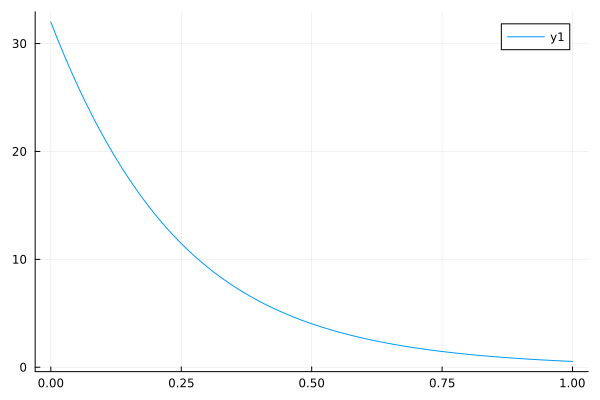

In [10]:
Eng = norm.(eachcol(Data["Xtst"][1]), 2).^2 / 2
plot(0.0:1e-4:1.0, Eng)

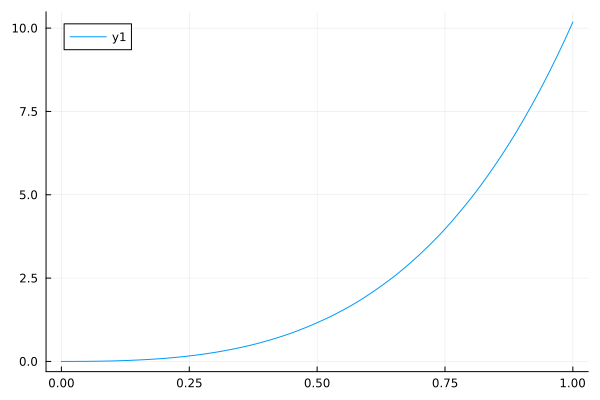

In [13]:
unko = norm.(eachcol(Data["Xtr_all"][1]), 2).^2 / 2
plot(0.0:1e-4:1.0, unko)

### Results

In [6]:
Data = load("data/epOpInf_data.jld2");

#### Projection Error

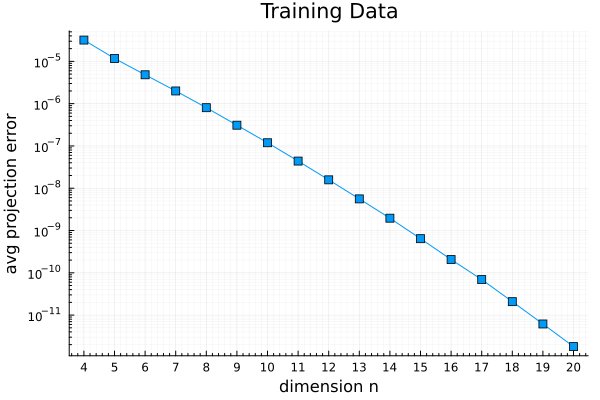

In [7]:
# Training data
mean_train_proj_err = mean(Data["train_proj_err"], dims=2)

plot(rmin:rmax, mean_train_proj_err, marker=(:rect))
plot!(yscale=:log10, majorgrid=true, minorgrid=true, legend=false)
tmp = log10.(mean_train_proj_err)
yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+1])
xticks!(rmin:rmax)
xlabel!("dimension n")
ylabel!("avg projection error")
title!("Training Data")

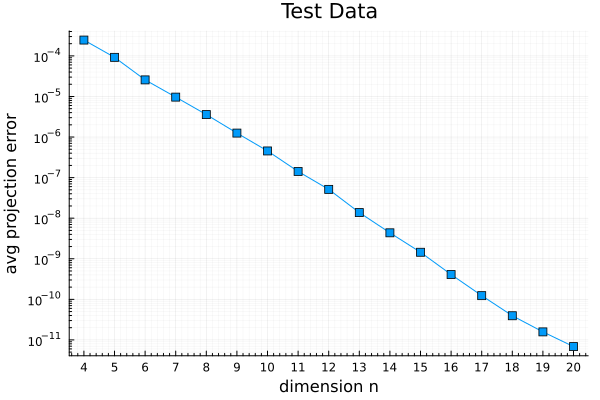

In [8]:
# Test data
mean_test_proj_err = mean(Data["test_proj_err"], dims=2)

plot(rmin:rmax, mean_test_proj_err, marker=(:rect))
plot!(yscale=:log10, majorgrid=true, minorgrid=true, legend=false)
tmp = log10.(mean_test_proj_err)
yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+1])
xticks!(rmin:rmax)
xlabel!("dimension n")
ylabel!("avg projection error")
title!("Test Data")

#### Mean relative state error

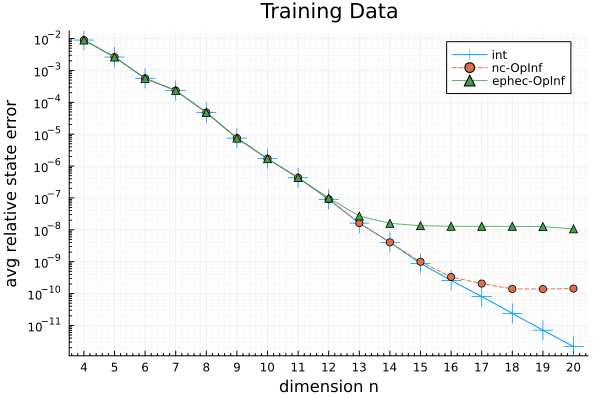

In [9]:
# Training data
mean_int_state_err = mean(Data["train_state_err"][:int], dims=2)
mean_nc_state_err = mean(Data["train_state_err"][:nc_OpInf], dims=2)
mean_ephec_state_err = mean(Data["train_state_err"][:ephec_OpInf], dims=2)

plot(rmin:rmax, mean_int_state_err, marker=(:cross, 10), label="int")
plot!(rmin:rmax, mean_nc_state_err, marker=(:circle), ls=:dash, label="nc-OpInf")
plot!(rmin:rmax, mean_ephec_state_err, marker=(:utriangle), ls=:dot, label="ephec-OpInf")
plot!(yscale=:log10, majorgrid=true, minorgrid=true, legend=:topright)
tmp = log10.(mean_int_state_err)
yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+1])
xticks!(rmin:rmax)
xlabel!("dimension n")
ylabel!("avg relative state error")
title!("Training Data")

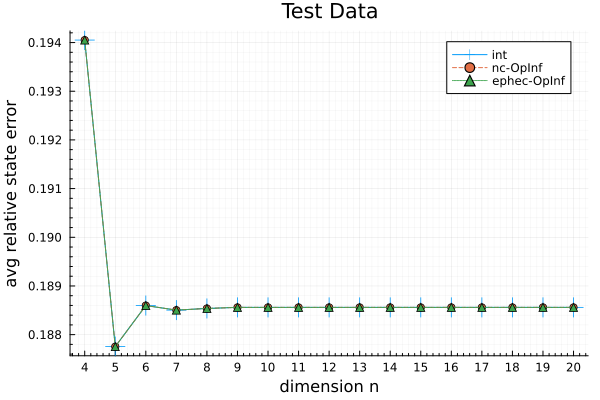

In [10]:
# Test data
mean_int_state_err = mean(Data["test_state_err"][:int], dims=2)
mean_nc_state_err = mean(Data["test_state_err"][:nc_OpInf], dims=2)
mean_ephec_state_err = mean(Data["test_state_err"][:ephec_OpInf], dims=2)

plot(rmin:rmax, mean_int_state_err, marker=(:cross, 10), label="int")
plot!(rmin:rmax, mean_nc_state_err, marker=(:circle), ls=:dash, label="nc-OpInf")
plot!(rmin:rmax, mean_ephec_state_err, marker=(:utriangle), ls=:dot, label="ephec-OpInf")
plot!(majorgrid=true, minorgrid=true, legend=:topright)
# plot!(yscale=:log10, majorgrid=true, minorgrid=true, legend=:topright)
# tmp = log10.(mean_int_state_err)
# yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+1])
xticks!(rmin:rmax)
xlabel!("dimension n")
ylabel!("avg relative state error")
title!("Test Data")

#### Total Energy

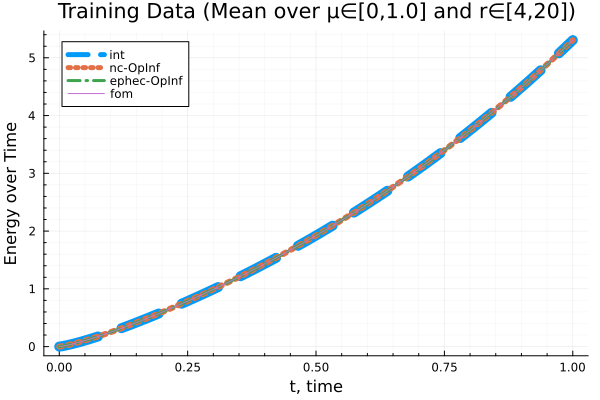

In [11]:
# Training data
DS = 20
mean_int_En_tr = mean(Data["train_En"][:int])
mean_nc_En_tr = mean(Data["train_En"][:nc_OpInf])
mean_ephec_En_tr = mean(Data["train_En"][:ephec_OpInf])
mean_fom_En_tr = mean(Data["train_En"][:fom])

plot(burger.t[1:DS:end], mean_int_En_tr, lw=10, ls=:dash, label="int")
plot!(burger.t[1:DS:end], mean_nc_En_tr, lw=6, ls=:dot, label="nc-OpInf")
plot!(burger.t[1:DS:end], mean_ephec_En_tr, lw=3, ls=:dashdot, label="ephec-OpInf")
plot!(burger.t[1:DS:end], mean_fom_En_tr, label="fom")
plot!(majorgrid=true, minorgrid=true, legend=:topleft)
xlabel!("t, time")
ylabel!("Energy over Time")
title!("Training Data (Mean over μ∈[0,1.0] and r∈[4,20])")

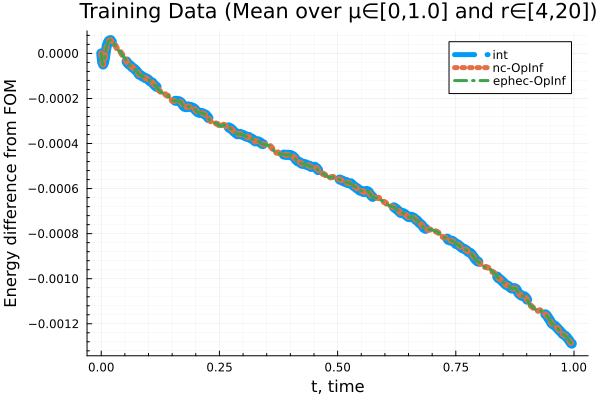

In [12]:
DS = 20
plot(burger.t[1:DS:end], mean_int_En_tr - mean_fom_En_tr, lw=10, ls=:dash, label="int")
plot!(burger.t[1:DS:end], mean_nc_En_tr - mean_fom_En_tr, lw=6, ls=:dot, label="nc-OpInf")
plot!(burger.t[1:DS:end], mean_ephec_En_tr - mean_fom_En_tr, lw=3, ls=:dashdot, label="ephec-OpInf")
plot!(majorgrid=true, minorgrid=true, legend=:topright)
xlabel!("t, time")
ylabel!("Energy difference from FOM")
title!("Training Data (Mean over μ∈[0,1.0] and r∈[4,20])")

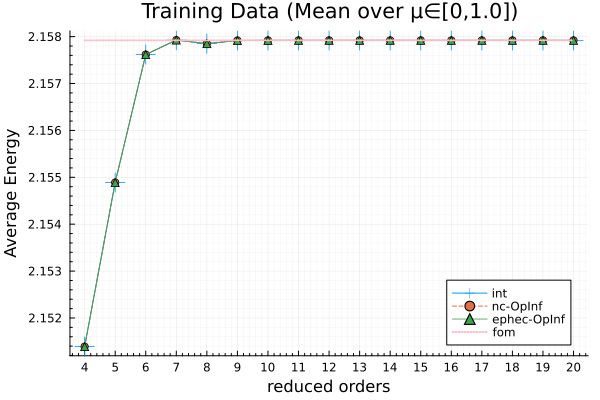

In [13]:
plot(rmin:rmax, mean.(mean(Data["train_En"][:int], dims=2)), marker=(:cross, 10), label="int")
plot!(rmin:rmax, mean.(mean(Data["train_En"][:nc_OpInf], dims=2)), marker=(:circle), ls=:dash, label="nc-OpInf")
plot!(rmin:rmax, mean.(mean(Data["train_En"][:ephec_OpInf], dims=2)), marker=(:utriangle), ls=:dot, label="ephec-OpInf")
plot!(rmin:rmax, mean(mean_fom_En_tr) * ones(length(rmin:rmax)), lc=:pink, ls=:dot, lw=2, label="fom")
plot!(majorgrid=true, minorgrid=true, legend=:bottomright)
xticks!(rmin:rmax)
xlabel!("reduced orders")
ylabel!("Average Energy")
title!("Training Data (Mean over μ∈[0,1.0])")

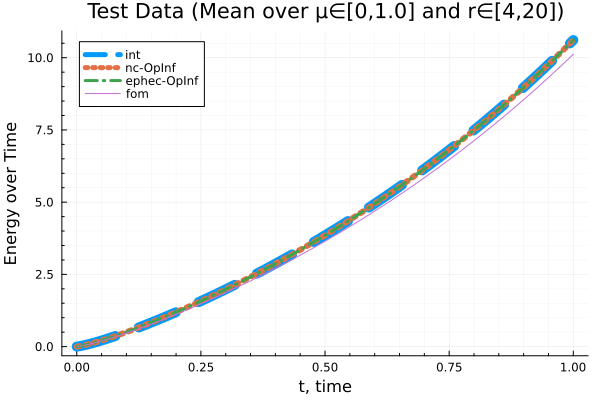

In [14]:
# Test data
DS = 20
mean_int_En_tst = mean(Data["test_En"][:int])
mean_nc_En_tst = mean(Data["test_En"][:nc_OpInf])
mean_ephec_En_tst = mean(Data["test_En"][:ephec_OpInf])
mean_fom_En_tst = mean(Data["test_En"][:fom])

plot(burger.t[1:DS:end], mean_int_En_tst, lw=10, ls=:dash, label="int")
plot!(burger.t[1:DS:end], mean_nc_En_tst, lw=6, ls=:dot, label="nc-OpInf")
plot!(burger.t[1:DS:end], mean_ephec_En_tst, lw=3, ls=:dashdot, label="ephec-OpInf")
plot!(burger.t[1:DS:end], mean_fom_En_tst, label="fom")
plot!(majorgrid=true, minorgrid=true, legend=:topleft)
xlabel!("t, time")
ylabel!("Energy over Time")
title!("Test Data (Mean over μ∈[0,1.0] and r∈[4,20])")

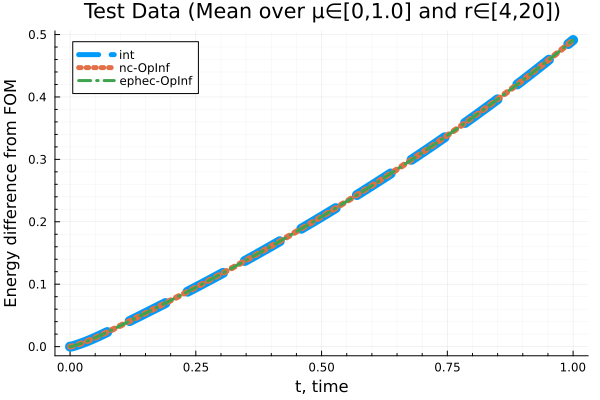

In [15]:
DS = 20
plot(burger.t[1:DS:end], mean_int_En_tst - mean_fom_En_tst, lw=10, ls=:dash, label="int")
plot!(burger.t[1:DS:end], mean_nc_En_tst - mean_fom_En_tst, lw=6, ls=:dot, label="nc-OpInf")
plot!(burger.t[1:DS:end], mean_ephec_En_tst - mean_fom_En_tst, lw=3, ls=:dashdot, label="ephec-OpInf")
plot!(majorgrid=true, minorgrid=true, legend=:topleft)
xlabel!("t, time")
ylabel!("Energy difference from FOM")
title!("Test Data (Mean over μ∈[0,1.0] and r∈[4,20])")

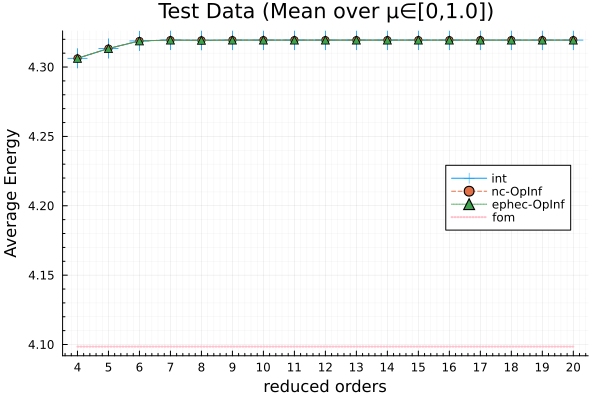

In [16]:
plot(rmin:rmax, mean.(mean(Data["test_En"][:int], dims=2)), marker=(:cross, 10), label="int")
plot!(rmin:rmax, mean.(mean(Data["test_En"][:nc_OpInf], dims=2)), marker=(:circle), ls=:dash, label="nc-OpInf")
plot!(rmin:rmax, mean.(mean(Data["test_En"][:ephec_OpInf], dims=2)), marker=(:utriangle), ls=:dot, label="ephec-OpInf")
plot!(rmin:rmax, mean(mean_fom_En_tst) * ones(length(rmin:rmax)), lc=:pink, ls=:dot, lw=2, label="fom")
plot!(majorgrid=true, minorgrid=true, legend=:right)
xticks!(rmin:rmax)
xlabel!("reduced orders")
ylabel!("Average Energy")
title!("Test Data (Mean over μ∈[0,1.0])")

#### Constraint Residual 

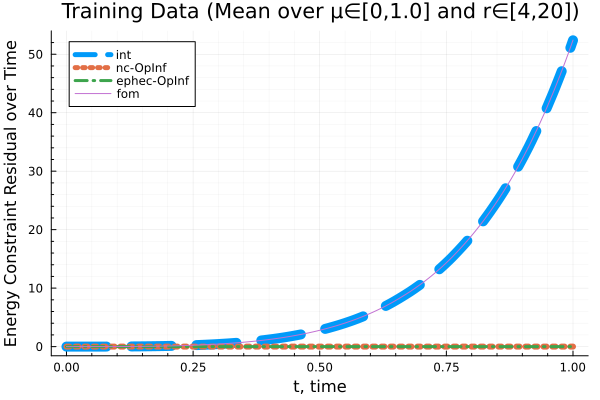

In [17]:
# Training data
DS = 20
mean_int_CR_tr = mean(Data["train_CR"][:int])
mean_nc_CR_tr = mean(Data["train_CR"][:nc_OpInf])
mean_ephec_CR_tr = mean(Data["train_CR"][:ephec_OpInf])
mean_fom_CR_tr = mean(Data["train_CR"][:fom])

plot(burger.t[1:DS:end], mean_int_CR_tr, lw=10, ls=:dash, label="int")
plot!(burger.t[1:DS:end], mean_nc_CR_tr, lw=6, ls=:dot, label="nc-OpInf")
plot!(burger.t[1:DS:end], mean_ephec_CR_tr, lw=3, ls=:dashdot, label="ephec-OpInf")
plot!(burger.t[1:DS:end], mean_fom_CR_tr, label="fom")
plot!(majorgrid=true, minorgrid=true, legend=:topleft)
xlabel!("t, time")
ylabel!("Energy Constraint Residual over Time")
title!("Training Data (Mean over μ∈[0,1.0] and r∈[4,20])")

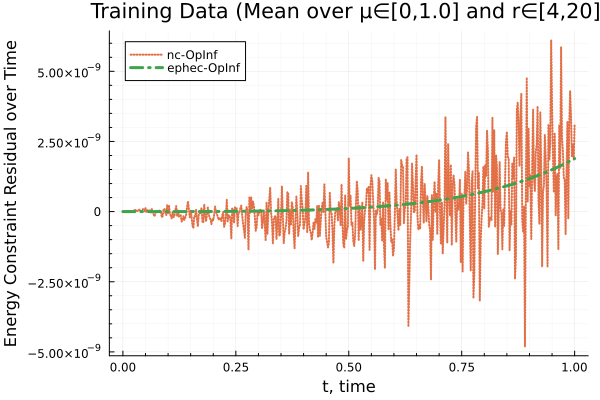

In [23]:
c1,c2,c3 = palette(:default)
plot(burger.t[1:DS:end], mean_nc_CR_tr, lw=2, ls=:dot, lc=c2, label="nc-OpInf")
plot!(burger.t[1:DS:end], mean_ephec_CR_tr, lw=3, ls=:dashdot, lc=c3, label="ephec-OpInf")
plot!(majorgrid=true, minorgrid=true, legend=:topleft)
xlabel!("t, time")
ylabel!("Energy Constraint Residual over Time")
title!("Training Data (Mean over μ∈[0,1.0] and r∈[4,20])")

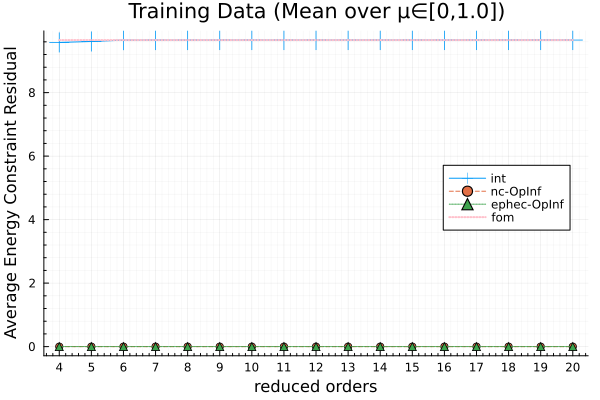

In [24]:
plot(rmin:rmax, mean.(mean(Data["train_CR"][:int], dims=2)), marker=(:cross, 10), label="int")
plot!(rmin:rmax, mean.(mean(Data["train_CR"][:nc_OpInf], dims=2)), marker=(:circle), ls=:dash, label="nc-OpInf")
plot!(rmin:rmax, mean.(mean(Data["train_CR"][:ephec_OpInf], dims=2)), marker=(:utriangle), ls=:dot, label="ephec-OpInf")
plot!(rmin:rmax, mean(mean(Data["train_CR"][:fom])) * ones(length(rmin:rmax)), lc=:pink, ls=:dot, lw=2, label="fom")
plot!(majorgrid=true, minorgrid=true, legend=:right)
xticks!(rmin:rmax)
xlabel!("reduced orders")
ylabel!("Average Energy Constraint Residual")
title!("Training Data (Mean over μ∈[0,1.0])")

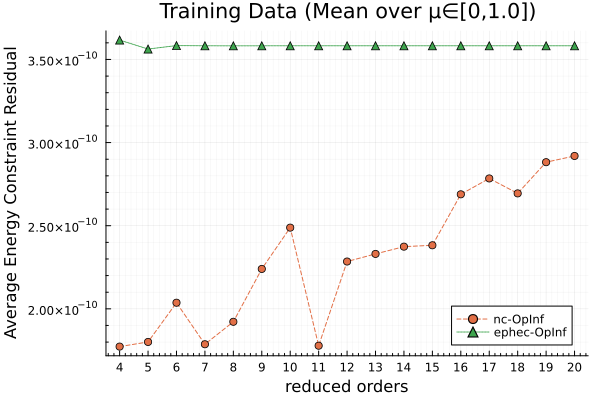

In [27]:
c1,c2,c3 = palette(:default)
plot(rmin:rmax, mean.(mean(Data["train_CR"][:nc_OpInf], dims=2)), marker=(:circle, c2), ls=:dash, lc=c2, label="nc-OpInf")
plot!(rmin:rmax, mean.(mean(Data["train_CR"][:ephec_OpInf], dims=2)), marker=(:utriangle, c3), ls=:dot, lc=c3, label="ephec-OpInf")
plot!(majorgrid=true, minorgrid=true, legend=:bottomright)
xticks!(rmin:rmax)
xlabel!("reduced orders")
ylabel!("Average Energy Constraint Residual")
title!("Training Data (Mean over μ∈[0,1.0])")

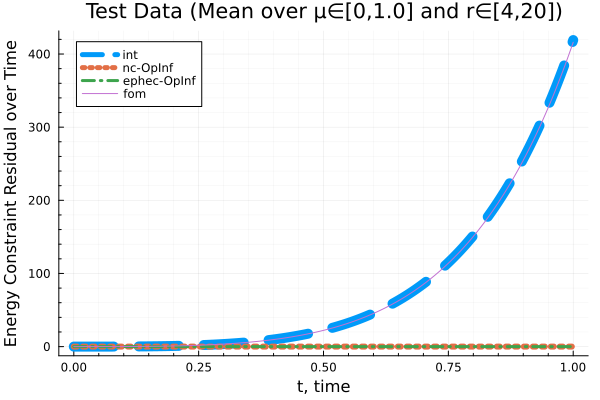

In [28]:
# Test data
DS = 20
mean_int_CR_tst = mean(Data["test_CR"][:int])
mean_nc_CR_tst = mean(Data["test_CR"][:nc_OpInf])
mean_ephec_CR_tst = mean(Data["test_CR"][:ephec_OpInf])
mean_fom_CR_tst = mean(Data["test_CR"][:fom])

plot(burger.t[1:DS:end], mean_int_CR_tst, lw=10, ls=:dash, label="int")
plot!(burger.t[1:DS:end], mean_nc_CR_tst, lw=6, ls=:dot, label="nc-OpInf")
plot!(burger.t[1:DS:end], mean_ephec_CR_tst, lw=3, ls=:dashdot, label="ephec-OpInf")
plot!(burger.t[1:DS:end], mean_fom_CR_tst, label="fom")
plot!(majorgrid=true, minorgrid=true, legend=:topleft)
xlabel!("t, time")
ylabel!("Energy Constraint Residual over Time")
title!("Test Data (Mean over μ∈[0,1.0] and r∈[4,20])")

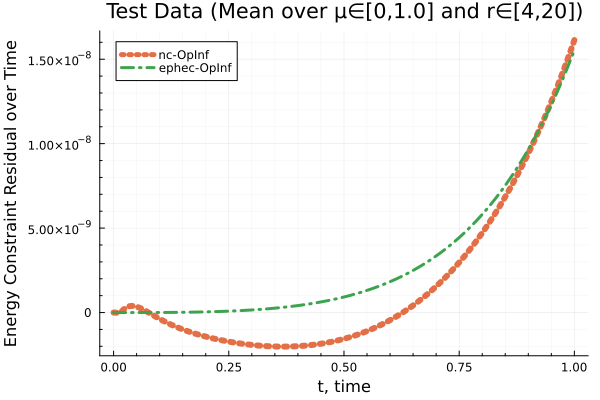

In [30]:
c1,c2,c3 = palette(:default)
plot(burger.t[1:DS:end], mean_nc_CR_tst, lw=6, ls=:dot, lc=c2, label="nc-OpInf")
plot!(burger.t[1:DS:end], mean_ephec_CR_tst, lw=3, ls=:dashdot, lc=c3, label="ephec-OpInf")
plot!(majorgrid=true, minorgrid=true, legend=:topleft)
xlabel!("t, time")
ylabel!("Energy Constraint Residual over Time")
title!("Test Data (Mean over μ∈[0,1.0] and r∈[4,20])")

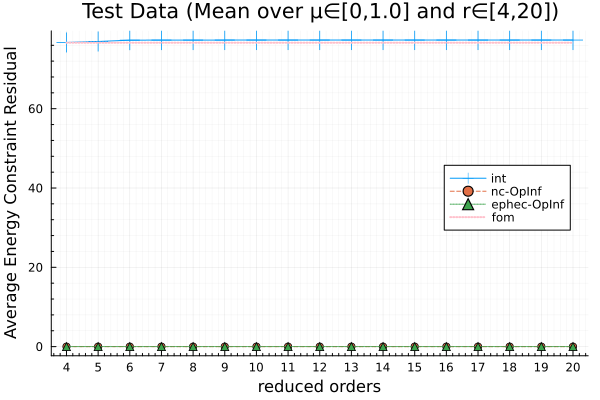

In [29]:
plot(rmin:rmax, mean.(mean(Data["test_CR"][:int], dims=2)), marker=(:cross, 10), label="int")
plot!(rmin:rmax, mean.(mean(Data["test_CR"][:nc_OpInf], dims=2)), marker=(:circle), ls=:dash, label="nc-OpInf")
plot!(rmin:rmax, mean.(mean(Data["test_CR"][:ephec_OpInf], dims=2)), marker=(:utriangle), ls=:dot, label="ephec-OpInf")
plot!(rmin:rmax, mean(mean(Data["test_CR"][:fom])) * ones(length(rmin:rmax)), lc=:pink, ls=:dot, lw=2, label="fom")
plot!(majorgrid=true, minorgrid=true, legend=:right)
xticks!(rmin:rmax)
xlabel!("reduced orders")
ylabel!("Average Energy Constraint Residual")
title!("Test Data (Mean over μ∈[0,1.0] and r∈[4,20])")

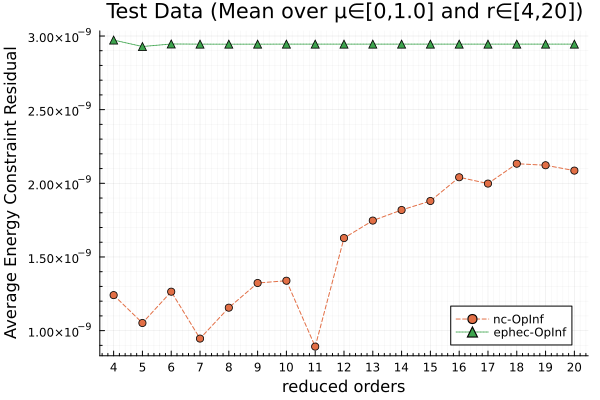

In [33]:
c1,c2,c3 = palette(:default)
plot(rmin:rmax, mean.(mean(Data["test_CR"][:nc_OpInf], dims=2)), marker=(:circle, c2), ls=:dash, lc=c2, label="nc-OpInf")
plot!(rmin:rmax, mean.(mean(Data["test_CR"][:ephec_OpInf], dims=2)), marker=(:utriangle, c3), ls=:dot, lc=c3, label="ephec-OpInf")
plot!(majorgrid=true, minorgrid=true, legend=:bottomright)
xticks!(rmin:rmax)
xlabel!("reduced orders")
ylabel!("Average Energy Constraint Residual")
title!("Test Data (Mean over μ∈[0,1.0] and r∈[4,20])")

#### Relative Constraint Residual

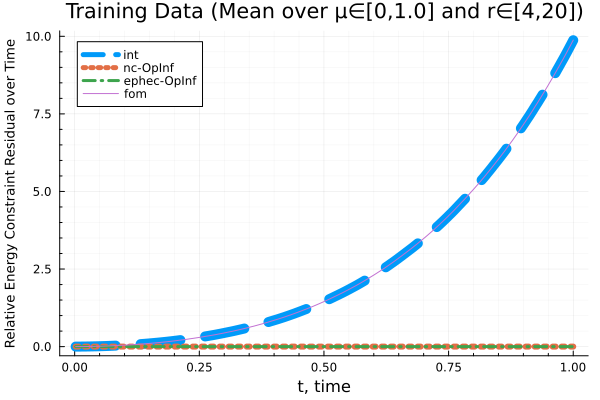

In [70]:
# Training data
DS = 20
mean_int_RCR_tr = mean_int_CR_tr ./ mean_int_En_tr
mean_nc_RCR_tr = mean_nc_CR_tr ./ mean_nc_En_tr
mean_ephec_RCR_tr = mean_ephec_CR_tr ./ mean_ephec_En_tr
mean_fom_RCR_tr = mean_fom_CR_tr ./ mean_fom_En_tr

plot(burger.t[1:DS:end], mean_int_RCR_tr, lw=10, ls=:dash, label="int")
plot!(burger.t[1:DS:end], mean_nc_RCR_tr, lw=6, ls=:dot, label="nc-OpInf")
plot!(burger.t[1:DS:end], mean_ephec_RCR_tr, lw=3, ls=:dashdot, label="ephec-OpInf")
plot!(burger.t[1:DS:end], mean_fom_RCR_tr, label="fom")
plot!(majorgrid=true, minorgrid=true, legend=:topleft)
plot!(yguidefontsize=9)
xlabel!("t, time")
ylabel!("Relative Energy Constraint Residual over Time")
title!("Training Data (Mean over μ∈[0,1.0] and r∈[4,20])")

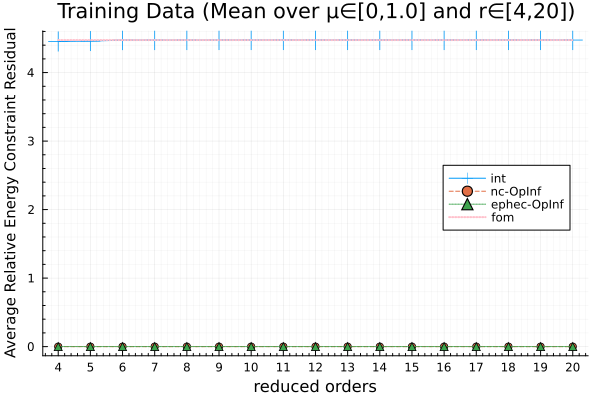

In [69]:
plot(rmin:rmax, mean.(mean(Data["train_CR"][:int], dims=2)) ./ mean.(mean(Data["train_En"][:int], dims=2)), marker=(:cross, 10), label="int")
plot!(rmin:rmax, mean.(mean(Data["train_CR"][:nc_OpInf], dims=2)) ./ mean.(mean(Data["train_En"][:nc_OpInf], dims=2)), marker=(:circle), ls=:dash, label="nc-OpInf")
plot!(rmin:rmax, mean.(mean(Data["train_CR"][:ephec_OpInf], dims=2)) ./ mean.(mean(Data["train_En"][:ephec_OpInf], dims=2)), marker=(:utriangle), ls=:dot, label="ephec-OpInf")
plot!(rmin:rmax, mean(mean(Data["train_CR"][:fom])) ./ mean(mean_fom_En_tr) * ones(length(rmin:rmax)), lc=:pink, ls=:dot, lw=2, label="fom")
plot!(majorgrid=true, minorgrid=true, legend=:right)
plot!(yguidefontsize=10)
xticks!(rmin:rmax)
xlabel!("reduced orders")
ylabel!("Average Relative Energy Constraint Residual")
title!("Training Data (Mean over μ∈[0,1.0] and r∈[4,20])")

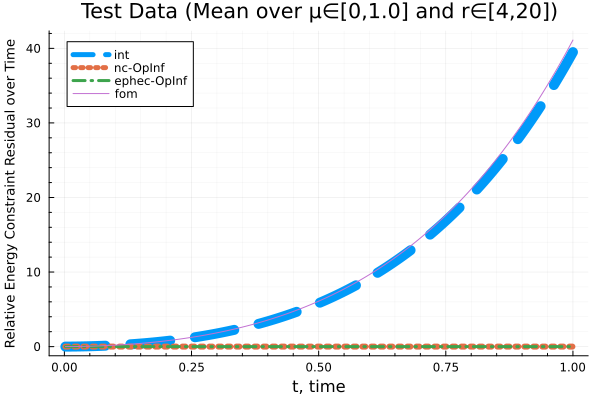

In [67]:
# Test data
DS = 20
mean_int_RCR_tst = mean_int_CR_tst ./ mean_int_En_tst
mean_nc_RCR_tst = mean_nc_CR_tst ./ mean_nc_En_tst
mean_ephec_RCR_tst = mean_ephec_CR_tst ./ mean_ephec_En_tst
mean_fom_RCR_tst = mean_fom_CR_tst ./ mean_fom_En_tst

plot(burger.t[1:DS:end], mean_int_RCR_tst, lw=10, ls=:dash, label="int")
plot!(burger.t[1:DS:end], mean_nc_RCR_tst, lw=6, ls=:dot, label="nc-OpInf")
plot!(burger.t[1:DS:end], mean_ephec_RCR_tst, lw=3, ls=:dashdot, label="ephec-OpInf")
plot!(burger.t[1:DS:end], mean_fom_RCR_tst, label="fom")
plot!(majorgrid=true, minorgrid=true, legend=:topleft)
plot!(yguidefontsize=9)
xlabel!("t, time")
ylabel!("Relative Energy Constraint Residual over Time")
title!("Test Data (Mean over μ∈[0,1.0] and r∈[4,20])")

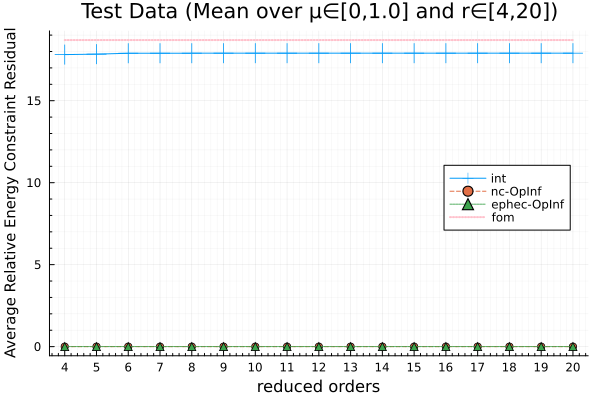

In [68]:
plot(rmin:rmax, mean.(mean(Data["test_CR"][:int], dims=2)) ./ mean.(mean(Data["test_En"][:int], dims=2)), marker=(:cross, 10), label="int")
plot!(rmin:rmax, mean.(mean(Data["test_CR"][:nc_OpInf], dims=2)) ./ mean.(mean(Data["test_En"][:nc_OpInf], dims=2)), marker=(:circle), ls=:dash, label="nc-OpInf")
plot!(rmin:rmax, mean.(mean(Data["test_CR"][:ephec_OpInf], dims=2)) ./ mean.(mean(Data["test_En"][:ephec_OpInf], dims=2)), marker=(:utriangle), ls=:dot, label="ephec-OpInf")
plot!(rmin:rmax, mean(mean(Data["test_CR"][:fom])) ./ mean(mean_fom_En_tst) * ones(length(rmin:rmax)), lc=:pink, ls=:dot, lw=2, label="fom")
plot!(majorgrid=true, minorgrid=true, legend=:right)
plot!(yguidefontsize=10)
xticks!(rmin:rmax)
xlabel!("reduced orders")
ylabel!("Average Relative Energy Constraint Residual")
title!("Test Data (Mean over μ∈[0,1.0] and r∈[4,20])")

In [26]:
# Compute the constraint residuals for all the Q and H matrices
ϵQ_int, ϵH_int, ϵQ_nc, ϵH_nc, ϵQ_ephec, ϵH_ephec = (zeros(length(rmin:rmax), burger.Pdim) for _ in 1:6)
ϵQ_fom, ϵH_fom = (zeros(burger.Pdim, 1) for _ in 1:2)

@showprogress for nr in 1:burger.Pdim
    for (i,r) in enumerate(rmin:rmax)
        H = LnL.extractH(Data["op_int"][nr].H, r)
        Q = LnL.H2Q(H)
        ϵQ_int[i,nr], ϵH_int[i,nr] = LnL.constraintResidual(Q, H, r)

        H = LnL.extractH(Data["op_nc_opinf"][nr].H, r)
        Q = LnL.H2Q(H)
        ϵQ_nc[i,nr], ϵH_nc[i,nr] = LnL.constraintResidual(Q, H, r)

        H = LnL.extractH(Data["op_ephec_opinf"][nr].H, r)
        Q = LnL.H2Q(H)
        ϵQ_ephec[i,nr], ϵH_ephec[i,nr] = LnL.constraintResidual(Q, H, r)
    end
    
    # FOM
    F_fom = Data["op_fom_tr"][nr].F
    H_fom = LnL.F2Hs(F_fom)
    Q_fom = LnL.H2Q(H_fom)
    ϵQ_fom[nr], ϵH_fom[nr] = LnL.constraintResidual(Q_fom, H_fom, size(H_fom, 1));
end

Progress: 100%|█████████████████████████████████████████| Time: 0:44:00


In [27]:
ϵ_CR = Dict(
    "int" => (ϵQ_int, ϵH_int),
    "nc_OpInf" => (ϵQ_nc, ϵH_nc),
    "ephec_OpInf" => (ϵQ_ephec, ϵH_ephec),
    "fom" => (ϵQ_fom, ϵH_fom)
)
Data["ϵ_CR"] = ϵ_CR
save("data/epOpInf_data.jld2", Data)

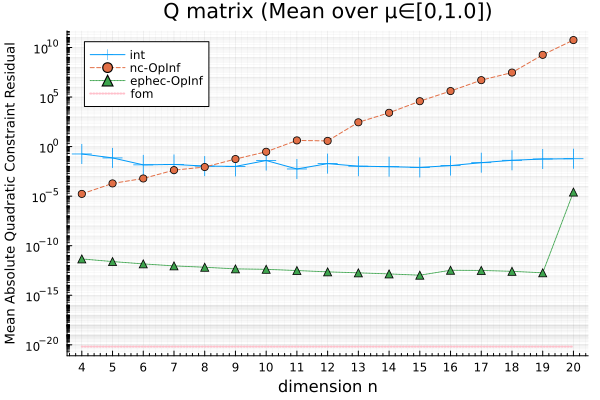

In [76]:
# Plot the constraint residuals for the intrusive operators
plot(rmin:rmax, mean(abs.(ϵQ_int), dims=2), marker=(:cross, 10), label="int")
plot!(rmin:rmax, mean(abs.(ϵQ_nc), dims=2), marker=(:circle), ls=:dash, label="nc-OpInf")
plot!(rmin:rmax, mean(abs.(ϵQ_ephec), dims=2), marker=(:utriangle), ls=:dot, label="ephec-OpInf")
plot!(rmin:rmax, mean(abs.(ϵQ_fom)) * ones(length(rmin:rmax)), lc=:pink, ls=:dot, lw=2, label="fom")
plot!(yscale=:log10, majorgrid=true, minorgrid=true, legend=:topleft)
plot!(yguidefontsize=9)
xticks!(rmin:rmax)
yticks!([1e-20, 1e-15, 1e-10, 1e-5, 1, 1e+5, 1e+10, 1e+15])
xlabel!("dimension n")
ylabel!("Mean Absolute Quadratic Constraint Residual")
title!("Q matrix (Mean over μ∈[0,1.0])")

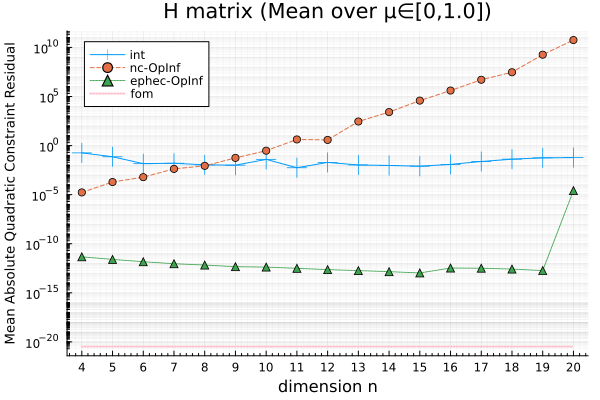

In [77]:
# Plot the constraint residuals for the intrusive operators
plot(rmin:rmax, mean(abs.(ϵH_int), dims=2), marker=(:cross, 10), label="int")
plot!(rmin:rmax, mean(abs.(ϵH_nc), dims=2), marker=(:circle), ls=:dash, label="nc-OpInf")
plot!(rmin:rmax, mean(abs.(ϵH_ephec), dims=2), marker=(:utriangle), ls=:dot, label="ephec-OpInf")
plot!(rmin:rmax, mean(abs.(ϵH_fom)) * ones(length(rmin:rmax)), lc=:pink, ls=:dot, lw=2, label="fom")
plot!(yscale=:log10, majorgrid=true, minorgrid=true, legend=:topleft)
plot!(yguidefontsize=9)
yticks!([1e-20, 1e-15, 1e-10, 1e-5, 1, 1e+5, 1e+10, 1e+15])
xticks!(rmin:rmax)
xlabel!("dimension n")
ylabel!("Mean Absolute Quadratic Constraint Residual")
title!("H matrix (Mean over μ∈[0,1.0])")